In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

###### we use exactly the trend in chapter 2, without making any further adjustment or analysis

### loading dataset

In [2]:
def load_data(path='dataset/owid-covid-data.csv') -> pd.DataFrame:
    return pd.read_csv(path)

In [3]:
covid_raw = load_data()
covid_raw.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
covid_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166326 entries, 0 to 166325
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    166326 non-null  object 
 1   continent                                   156370 non-null  object 
 2   location                                    166326 non-null  object 
 3   date                                        166326 non-null  object 
 4   total_cases                                 163293 non-null  float64
 5   new_cases                                   163133 non-null  float64
 6   new_cases_smoothed                          161150 non-null  float64
 7   total_deaths                                145451 non-null  float64
 8   new_deaths                                  145487 non-null  float64
 9   new_deaths_smoothed                         143390 non-null  float64
 

In [5]:
covid_rf =  covid_raw[['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'people_fully_vaccinated',
                       'total_deaths_per_million', 'new_deaths_per_million', 'reproduction_rate', 'total_tests', 'population', 'population_density', 'aged_65_older', 'total_boosters']]

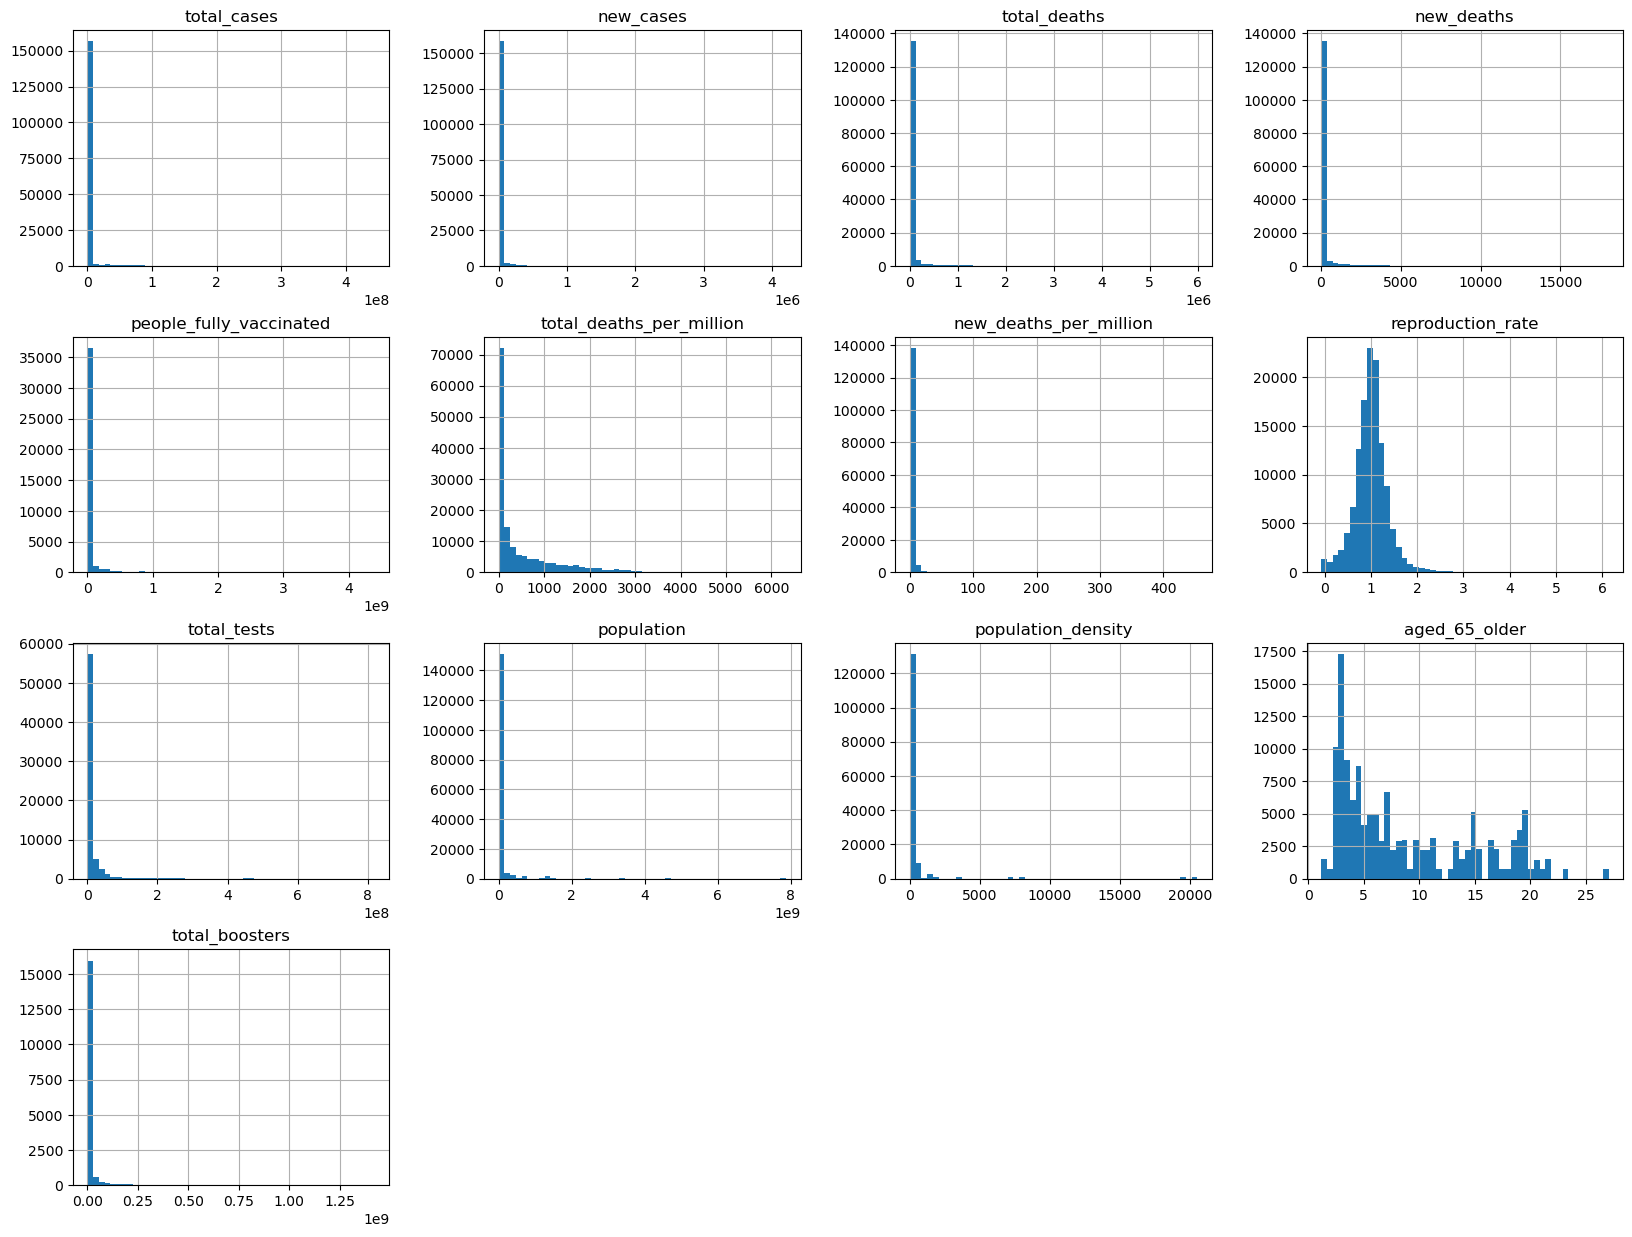

In [6]:
covid_rf.hist(bins=50, figsize=(20, 15))
plt.show()

### correlations

In [7]:
corr_matrix =  covid_rf.corr()

corr_matrix['total_deaths'].sort_values(ascending=False)

total_deaths                1.000000
total_cases                 0.967826
total_tests                 0.821974
people_fully_vaccinated     0.793905
new_deaths                  0.779774
new_cases                   0.736538
population                  0.678685
total_boosters              0.569922
total_deaths_per_million    0.144752
aged_65_older               0.026322
new_deaths_per_million      0.022830
reproduction_rate           0.007228
population_density         -0.020150
Name: total_deaths, dtype: float64

### clean data with imputer

In [8]:
# imputer = SimpleImputer(strategy="median")
# imputer.fit_transform(covid_rf_num)
# covid_rf_num.median().values

In [9]:
# X = imputer.transform(covid_rf_num)
# covid_tr = pd.DataFrame(X, columns=covid_rf_num.columns, index=covid_rf_num.index)

# covid_tr

##### custom transformers

In [10]:
class CustomTransformer(BaseEstimator, TransformerMixin):

    def __init__(self) -> None:
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X

##### feature scaling  (eg. min-max scaling (normalization = X -  min/(max-min)) and standardization)

##### pipeline (for imputers, transformers and featurescaling)

In [11]:
num_basic_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('custom_trans', CustomTransformer()),
    ('std_scaler', StandardScaler())
])


covid_num_tr = num_basic_pipeline.fit_transform(covid_rf)

covid_clean = pd.DataFrame(covid_num_tr, columns=covid_rf.columns, index=covid_rf.index)
covid_clean

,total_cases,new_cases,total_deaths,new_deaths,people_fully_vaccinated,total_deaths_per_million,new_deaths_per_million,reproduction_rate,total_tests,population,population_density,aged_65_older,total_boosters
0,-0.162798,-0.135666,-0.175676,-0.189582,-0.098823,-0.446917,-0.280825,-0.002423,-0.152187,-0.151714,-0.181658,-1.029967,-0.065552
1,-0.162798,-0.135726,-0.175676,-0.189582,-0.098823,-0.446917,-0.280825,-0.002423,-0.152187,-0.151714,-0.181658,-1.029967,-0.065552
2,-0.162798,-0.135726,-0.175676,-0.189582,-0.098823,-0.446917,-0.280825,-0.002423,-0.152187,-0.151714,-0.181658,-1.029967,-0.065552
3,-0.162798,-0.135726,-0.175676,-0.189582,-0.098823,-0.446917,-0.280825,-0.002423,-0.152187,-0.151714,-0.181658,-1.029967,-0.065552
4,-0.162798,-0.135726,-0.175676,-0.189582,-0.098823,-0.446917,-0.280825,-0.002423,-0.152187,-0.151714,-0.181658,-1.029967,-0.065552
...,...,...,...,...,...,...,...,...,...,...,...,...,...
166321,-0.147313,-0.129854,-0.159387,-0.192145,-0.091711,-0.137702,-0.307100,1.059378,-0.152187,-0.186896,-0.187431,-0.987128,-0.075599
166322,-0.147272,-0.128168,-0.159384,-0.190864,-0.091696,-0.137613,-0.293445,1.028149,-0.149013,-0.186896,-0.187431,-0.987128,-0.075466
166323,-0.147272,-0.135726,-0.159384,-0.192145,-0.091671,-0.137613,-0.307100,-0.002423,-0.152187,-0.186896,-0.187431,-0.987128,-0.075395
166324,-0.147191,-0.120946,-0.159380,-0.190864,-0.091659,-0.137523,-0.293445,-0.002423,-0.148898,-0.186896,-0.187431,-0.987128,-0.075215


In [12]:
train_set, test_set = train_test_split(covid_clean, test_size=0.2, random_state=42)

# using stratified spliting 
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
# for train_index, test_index in split.split(covid_clean, covid_clean['total_deaths']):
#     strat_train_set = covid_rf.loc[train_index]
#     strat_test_set = covid_rf.loc[test_index]

print(len(train_set))  
print(len(test_set)) 

covid_train = train_set.drop("total_deaths", axis=1)
covid_train_label = train_set["total_deaths"]

133060
33266


In [13]:
covid = covid_clean.drop("total_deaths", axis=1)
covid_label = covid_clean["total_deaths"]

### select and train model

#### Linear regression

In [14]:
lin_reg = LinearRegression()
lin_reg.fit(X=covid_train, y=covid_train_label)

LinearRegression()

In [15]:
some_data =  covid.iloc[:5]
some_labels = covid_label[:5]
print("Predictions: ", lin_reg.predict(some_data))
print("Labels: ", some_labels)

Predictions:  [-0.17224439 -0.17223891 -0.17223891 -0.17223891 -0.17223891]
Labels:  0   -0.175676
1   -0.175676
2   -0.175676
3   -0.175676
4   -0.175676
Name: total_deaths, dtype: float64


In [16]:
predictions = lin_reg.predict(covid_train)
lin_mse = mean_squared_error(y_true=covid_train_label, y_pred=predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.17754672621468293

##### DecisionTree regression

In [17]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X=covid_train, y=covid_train_label)

DecisionTreeRegressor()

In [18]:
predictions = tree_reg.predict(covid_train)
tree_mse = mean_squared_error(y_true=covid_train_label, y_pred=predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

7.606221111518755e-08

###### cross validating decision tree

In [19]:
scores = cross_val_score(tree_reg, covid_train, covid_train_label, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)
tree_rmse.std()

0.0

#### Random forest regressor

In [20]:
forest_reg = RandomForestRegressor()
forest_reg.fit(covid_train, covid_train_label)

RandomForestRegressor()

In [21]:
forest_mse = mean_squared_error(y_true=covid_train_label, y_pred=predictions)
forest_rmse = np.square(forest_mse)
forest_rmse.std()

0.0

### Fine tuning

In [22]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}, 
]

In [25]:
## using it on ramdom forest regressor

grid_search = GridSearchCV(forest_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

In [26]:
grid_search.fit(covid_train, covid_train_label)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [27]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [29]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.04364175333717922 {'max_features': 2, 'n_estimators': 3}
0.029304124215095855 {'max_features': 2, 'n_estimators': 10}
0.021010855640387672 {'max_features': 2, 'n_estimators': 30}
0.0353823143053842 {'max_features': 4, 'n_estimators': 3}
0.018600721311689276 {'max_features': 4, 'n_estimators': 10}
0.014161507587737356 {'max_features': 4, 'n_estimators': 30}
0.01948453699250384 {'max_features': 6, 'n_estimators': 3}
0.014860731951658865 {'max_features': 6, 'n_estimators': 10}
0.01122674934451127 {'max_features': 6, 'n_estimators': 30}
0.022091376101714244 {'max_features': 8, 'n_estimators': 3}
0.014435854722267109 {'max_features': 8, 'n_estimators': 10}
0.009512597798163819 {'max_features': 8, 'n_estimators': 30}
0.03379837844762844 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.022119622009461937 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.034351093193441304 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.016232652509462066 {'bootstrap': Fa

In [33]:
final_model = grid_search.best_estimator_

#### evaluate on test set

In [35]:
X_test = test_set.drop("total_deaths", axis=1)
y_test = test_set["total_deaths"].copy()

In [39]:
final_predictions =  final_model.predict(X_test)

final_mse =  mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

0.008583419466704163